In [194]:
# Converted from notebook: compas_analysis.ipynb

#!/usr/bin/env python
# coding: utf-8

# # Compas Analysis



In [195]:


get_ipython().system('pip install pandas numpy matplotlib seaborn statsmodels -q')

from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf

sns.set(style="whitegrid")





[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [196]:


raw_data = pd.read_csv("dataset/compas-scores-two-years.csv")
print(f"Total rows number: {len(raw_data)}")




Total rows number: 7214


In [197]:


df = raw_data.loc[:, [
    'age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex',
    'priors_count', 'days_b_screening_arrest', 'decile_score',
    'is_recid', 'two_year_recid', 'c_jail_in', 'c_jail_out',
    'compas_screening_date'    # ← add this
]]




In [198]:


df['screening_date'] = pd.to_datetime(df['compas_screening_date'])
cutoff = pd.Timestamp('2014-04-01')




In [199]:


df = df[df['screening_date'] <= cutoff].copy()
print(f"Rows after two-year cutoff: {len(df)}")




Rows after two-year cutoff: 6216


In [200]:


# We filter out rows for several reasons: (similar to the Propublica study)
# 1. Screening date not within ±30 days of arrest  
# 2. Missing recidivism flag (`is_recid == -1`)  
# 3. Non-jailable offenses (`c_charge_degree == 'O'`)  
# 4. Missing COMPAS score text (`score_text == 'N/A'`)  
# 5. Only individuals with either two-year recidivism or ≥2 years out of jail




In [201]:


df = df[
    df['days_b_screening_arrest'].between(-30, 30) &
    (df['is_recid'] != -1) &
    (df['c_charge_degree'] != 'O') &
    (df['score_text'] != 'N/A')
].copy()

print(f"Rows after filtering: {len(df)}")




Rows after filtering: 5304


In [202]:


#length of jail stay and its correlation with COMPAS decile score.

df['c_jail_in'] = pd.to_datetime(df['c_jail_in'])
df['c_jail_out'] = pd.to_datetime(df['c_jail_out'])
df['length_of_stay'] = (df['c_jail_out'] - df['c_jail_in']).dt.days

corr = df[['length_of_stay', 'decile_score']].corr().iloc[0,1]
print(f"Correlation between length_of_stay and decile_score: {corr:.4f}")


# After filtering we have the following demographic breakdown:



Correlation between length_of_stay and decile_score: 0.2115


In [203]:


print(df['age_cat'].value_counts(dropna=False))




age_cat
25 - 45            3031
Greater than 45    1165
Less than 25       1108
Name: count, dtype: int64


In [204]:


print(df['race'].value_counts(dropna=False))




race
African-American    2682
Caucasian           1829
Hispanic             448
Other                309
Asian                 27
Native American        9
Name: count, dtype: int64


In [205]:


total = len(df)
for race, count in df['race'].value_counts().items():
    print(f"{race}: {count/total*100:.2f}%")




African-American: 50.57%
Caucasian: 34.48%
Hispanic: 8.45%
Other: 5.83%
Asian: 0.51%
Native American: 0.17%


In [206]:


print(df['score_text'].value_counts())




score_text
Low       3086
Medium    1329
High       889
Name: count, dtype: int64


In [207]:


print(pd.crosstab(df['sex'], df['race']))




race    African-American  Asian  Caucasian  Hispanic  Native American  Other
sex                                                                         
Female               474      1        414        73                2     53
Male                2208     26       1415       375                7    256


In [208]:


sex_counts = df['sex'].value_counts()
for sex, count in sex_counts.items():
    print(f"{sex}: {count/total*100:.2f}%")




Male: 80.83%
Female: 19.17%


In [209]:


recid_count = df['two_year_recid'].sum()
print(f"\nNumber of recidivists: {recid_count}")
print(f"Recidivism rate: {recid_count/total*100:.2f}%")





Number of recidivists: 1941
Recidivism rate: 36.60%


In [210]:


fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

sns.countplot(x='decile_score', data=df[df['race']=="African-American"],
              order=sorted(df['decile_score'].unique()),
              ax=axes[0])
axes[0].set_title("Black Defendants' Decile Scores")
axes[0].set_ylim(0, 650)

sns.countplot(x='decile_score', data=df[df['race']=="Caucasian"],
              order=sorted(df['decile_score'].unique()),
              ax=axes[1])
axes[1].set_title("White Defendants' Decile Scores")
axes[1].set_ylim(0, 650)

for ax in axes:
    ax.set_xlabel("Decile Score")
    ax.set_ylabel("Count")

plt.tight_layout()




In [211]:


pd.crosstab(df['decile_score'], df['race'])


# ## Racial Bias in Compas
# 
# We run a logistic regression predicting High vs. Low COMPAS score (`score_text != 'Low'`) as a function of gender, age category, race, number of priors, charge degree, and recidivism.



race,African-American,Asian,Caucasian,Hispanic,Native American,Other
decile_score,,,,,,
1,338,14,570,146,0,136
2,316,4,277,77,2,53
3,264,4,214,64,1,28
4,288,0,214,43,0,33
5,265,1,168,31,0,17
6,262,2,133,23,2,17
7,280,0,93,25,2,8
8,246,2,66,12,0,4
9,256,0,59,17,1,6


In [212]:


df['high_score'] = (df['score_text'] != 'Low').astype(int)




In [213]:


df['race_cat'] = pd.Categorical(
    df['race'],
    categories=[
        'Caucasian',
        'African-American',
        'Asian',
        'Hispanic',
        'Native American',
        'Other'
    ],
    ordered=False
)

model = smf.logit(
    formula=(
        "high_score ~ "
        "C(sex) + "
        "C(age_cat) + "
        "C(race_cat, Treatment(reference='Caucasian')) + "
        "priors_count + "
        "C(c_charge_degree) + "
        "two_year_recid"
    ),
    data=df
).fit(disp=False)




In [214]:


# Extract the corrected coefficients:
intercept    = model.params['Intercept']
beta_black   = model.params["C(race_cat, Treatment(reference='Caucasian'))[T.African-American]"]
beta_male    = model.params['C(sex)[T.Male]']
beta_under25 = model.params['C(age_cat)[T.Less than 25]']

# Baseline probability for the reference group (Caucasian female, age 25–45, 0 priors, no recid)
p0 = np.exp(intercept) / (1 + np.exp(intercept))
print(f"Baseline P(high_score): {p0:.3f}")

# Adjusted probability ratios
def adj_ratio(beta):
    num = np.exp(beta)
    return num / (1 - p0 + p0 * num)

print(f"African-American vs. White ratio: {adj_ratio(beta_black):.3f}")
print(f"Male vs. Female ratio:           {adj_ratio(beta_male):.3f}")
print(f"<25 vs. 25–45 ratio:             {adj_ratio(beta_under25):.3f}")


# - **African-American vs. White**: Black defendants are **1.43×** as likely as White defendants to receive a High score (≈ 42.5 % higher probability).  
# - **Male vs. Female**: Male defendants are **0.84×** as likely as female defendants to get a High score (≈ 16.3 % lower probability).  
# - **Under 25 vs. 25–45**: Defendants under 25 are **2.35×** as likely as 25–45-year-olds to be classified High Risk (≈ 134.7 % higher probability).  
# 

# # Chapter 2: Exploratory Data Analysis (EDA)
# 

# ## 1. Summary Statistics



Baseline P(high_score): 0.209
African-American vs. White ratio: 1.440
Male vs. Female ratio:           0.831
<25 vs. 25–45 ratio:             2.430


In [215]:


# Compute descriptive statistics for selected numeric columns using quantiles
num_cols = ['age', 'priors_count', 'decile_score', 'length_of_stay']
summary_stats = pd.DataFrame({
    'mean': df[num_cols].mean(),
    'median': df[num_cols].median(),
    'std': df[num_cols].std(),
    'min': df[num_cols].min(),
    '25%': df[num_cols].quantile(0.25),
    '50%': df[num_cols].quantile(0.5),
    '75%': df[num_cols].quantile(0.75),
    'max': df[num_cols].max()
}).T
summary_stats


# ## 2. Distribution Plots



,age,priors_count,decile_score,length_of_stay
mean,34.953431,2.993590,4.240196,14.740950
median,32.000000,1.000000,4.000000,1.000000
std,11.817771,4.458153,2.801026,47.888538
min,19.000000,0.000000,1.000000,-1.000000
25%,25.000000,0.000000,2.000000,0.000000
50%,32.000000,1.000000,4.000000,1.000000
75%,43.000000,4.000000,6.000000,5.000000
max,96.000000,37.000000,10.000000,799.000000


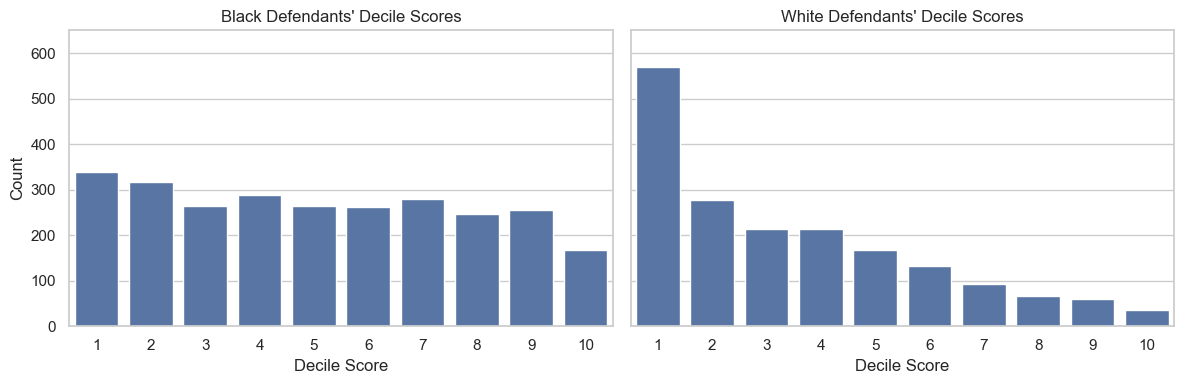

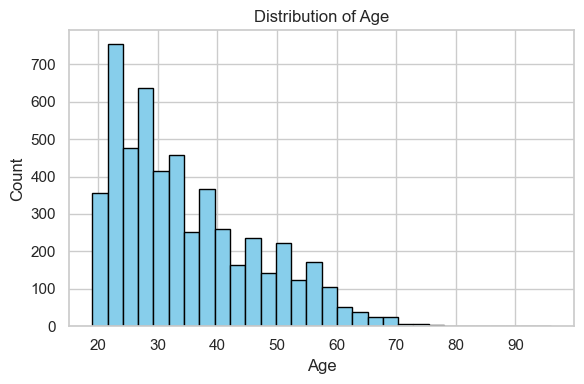

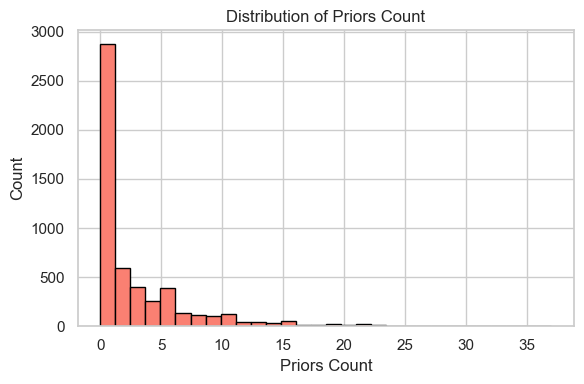

In [216]:


import os

os.makedirs("figures", exist_ok=True)

# Histogram for age
plt.figure(figsize=(6,4))
plt.hist(df['age'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Distribution of Age')
plt.tight_layout()
plt.savefig('figures/age_hist.png')
plt.show()

# %%
# Histogram for priors_count
plt.figure(figsize=(6,4))
plt.hist(df['priors_count'], bins=30, color='salmon', edgecolor='black')
plt.xlabel('Priors Count')
plt.ylabel('Count')
plt.title('Distribution of Priors Count')
plt.tight_layout()
plt.savefig('figures/priors_count_hist.png')
plt.show()


# ## 3. Categorical Counts



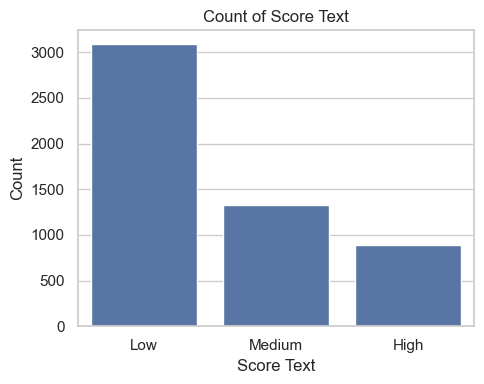

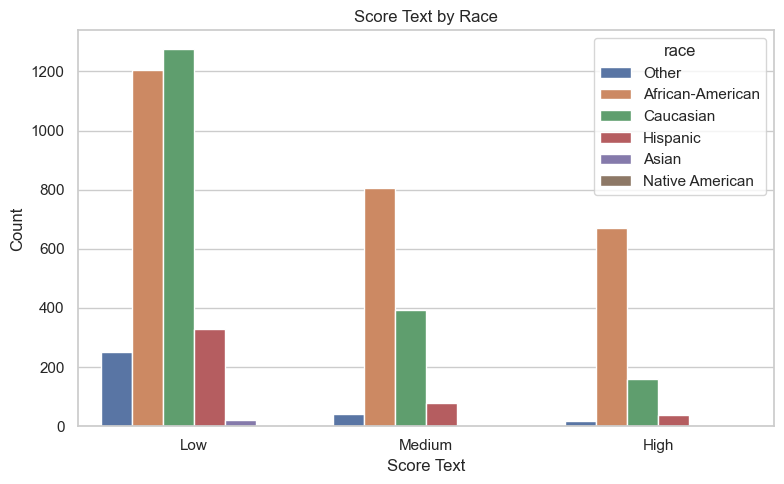

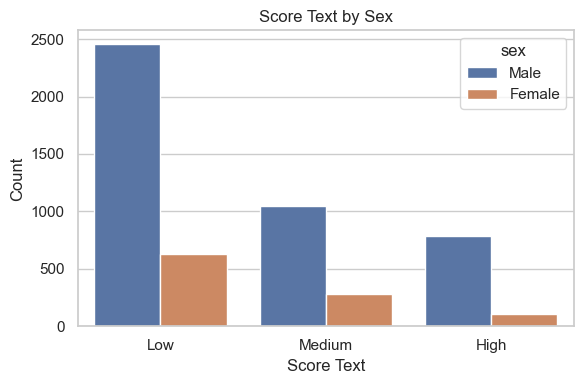

In [217]:


# Countplot for score_text overall
plt.figure(figsize=(5,4))
sns.countplot(x='score_text', data=df, order=['Low', 'Medium', 'High'])
plt.xlabel('Score Text')
plt.ylabel('Count')
plt.title('Count of Score Text')
plt.tight_layout()
plt.savefig('figures/score_text_count.png')
plt.show()

# %%
# Countplot for score_text by race
plt.figure(figsize=(8,5))
sns.countplot(x='score_text', hue='race', data=df, order=['Low', 'Medium', 'High'])
plt.xlabel('Score Text')
plt.ylabel('Count')
plt.title('Score Text by Race')
plt.tight_layout()
plt.savefig('figures/score_text_by_race.png')
plt.show()

# %%
# Countplot for score_text by sex
plt.figure(figsize=(6,4))
sns.countplot(x='score_text', hue='sex', data=df, order=['Low', 'Medium', 'High'])
plt.xlabel('Score Text')
plt.ylabel('Count')
plt.title('Score Text by Sex')
plt.tight_layout()
plt.savefig('figures/score_text_by_sex.png')
plt.show()


# ## 4. Grouped Recidivism Rates



In [218]:


# Recidivism rate by race
recid_by_race = df.groupby('race')['two_year_recid'].mean().sort_values(ascending=False)
print("Recidivism Rate by Race:")
print(recid_by_race)

# %%
# Recidivism rate by age_cat
recid_by_age = df.groupby('age_cat')['two_year_recid'].mean().sort_values(ascending=False)
print("Recidivism Rate by Age Category:")
print(recid_by_age)

# %%
# Recidivism rate by c_charge_degree
recid_by_charge = df.groupby('c_charge_degree')['two_year_recid'].mean().sort_values(ascending=False)
print("Recidivism Rate by Charge Degree:")
print(recid_by_charge)


# # Chapter 3: Predictive Modeling and Fairness Evaluation

# ## 1. Train/Test Split



Recidivism Rate by Race:
race
African-American    0.435496
Native American     0.333333
Caucasian           0.299617
Other               0.291262
Hispanic            0.285714
Asian               0.148148
Name: two_year_recid, dtype: float64
Recidivism Rate by Age Category:
age_cat
Less than 25       0.464801
25 - 45            0.376113
Greater than 45    0.245494
Name: two_year_recid, dtype: float64
Recidivism Rate by Charge Degree:
c_charge_degree
F    0.404676
M    0.300305
Name: two_year_recid, dtype: float64


In [219]:


import os

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import train_test_split

# Create directories if they don't exist
os.makedirs("figures", exist_ok=True)
os.makedirs("models", exist_ok=True)

# Get one-hot encodings for categorical features
categorical_features = pd.get_dummies(df[['race', 'sex', 'c_charge_degree']], drop_first=False)

# Create feature matrix
X = pd.concat([
    df[['decile_score', 'priors_count', 'age']],
    categorical_features
], axis=1)

# Define target variable
y = df['two_year_recid']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)


# ## 2. Model Training



In [220]:


# Create and fit logistic regression model
model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)




LogisticRegression(solver='liblinear')

In [221]:


# Create and fit XGBoost model
print("\nTraining XGBoost model...")
# Added use_label_encoder=False to avoid a warning with recent xgboost versions
# Added eval_metric to specify for potential future use or suppress warnings
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
print("XGBoost model trained.")


# ## 3. Performance Metrics




Training XGBoost model...
XGBoost model trained.


/Users/albertsteenstrup/.pyenv/versions/3.12.9/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:24:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [222]:


# Predict on test set
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Compute ROC AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC: {roc_auc:.4f}")




Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.89      0.80      1009
           1       0.70      0.44      0.54       583

    accuracy                           0.72      1592
   macro avg       0.72      0.66      0.67      1592
weighted avg       0.72      0.72      0.71      1592

ROC AUC: 0.7618


In [223]:


# Predict on test set with XGBoost
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Print classification report for XGBoost
print("\nClassification Report (XGBoost):")
print(classification_report(y_test, y_pred_xgb))

# Compute ROC AUC for XGBoost
roc_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
print(f"ROC AUC (XGBoost): {roc_auc_xgb:.4f}")


# ## 4. ROC Curve




Classification Report (XGBoost):
              precision    recall  f1-score   support

           0       0.73      0.82      0.77      1009
           1       0.61      0.49      0.54       583

    accuracy                           0.70      1592
   macro avg       0.67      0.65      0.66      1592
weighted avg       0.69      0.70      0.69      1592

ROC AUC (XGBoost): 0.7246


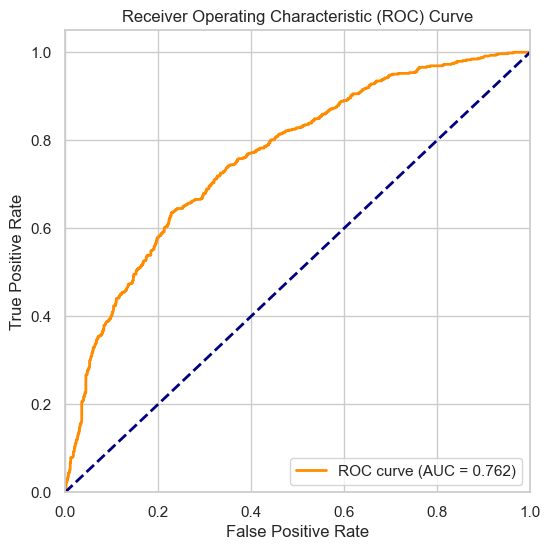

In [224]:


# Compute ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('figures/roc_curve.png')
plt.show()




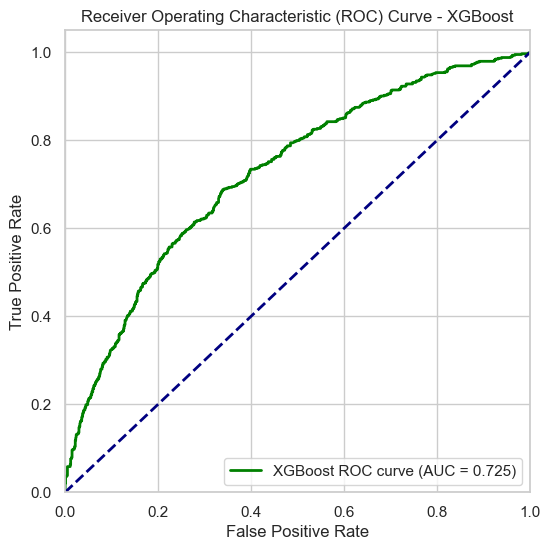

In [225]:


# Compute ROC curve points for XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)

# Plot ROC curve for XGBoost
plt.figure(figsize=(6, 6))
plt.plot(fpr_xgb, tpr_xgb, color='green', lw=2, label=f'XGBoost ROC curve (AUC = {roc_auc_xgb:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - XGBoost')
plt.legend(loc="lower right")
plt.savefig('figures/roc_curve_xgb.png')
plt.show()


# ## 5. Fairness Metrics by Race



In [226]:


# Create a DataFrame to store fairness metrics
fairness_metrics = []

# Get race values from test data (need to reconstruct from one-hot columns)
race_columns = [col for col in X_test.columns if col.startswith('race_')]
test_indices = X_test.index

# Recreate race column for test set
test_with_race = pd.DataFrame({'race': df.loc[test_indices, 'race']})
test_with_race['y_true'] = y_test.values
test_with_race['y_pred'] = y_pred

# Calculate metrics for each race
for race in test_with_race['race'].unique():
    race_mask = test_with_race['race'] == race

    # Get race-specific predictions and labels
    y_true_race = test_with_race.loc[race_mask, 'y_true']
    y_pred_race = test_with_race.loc[race_mask, 'y_pred']

    # Compute confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true_race, y_pred_race).ravel()

    # Calculate FPR and FNR
    fpr = fp / (fp + tn) if (fp + tn) > 0 else np.nan
    fnr = fn / (fn + tp) if (fn + tp) > 0 else np.nan

    # Add to results
    fairness_metrics.append({
        'race': race,
        'count': len(y_true_race),
        'FPR': fpr,
        'FNR': fnr
    })

# Create DataFrame and display results
fairness_df = pd.DataFrame(fairness_metrics)
fairness_df = fairness_df.sort_values('count', ascending=False)
print("Fairness Metrics by Race:")
print(fairness_df)




Fairness Metrics by Race:
               race  count       FPR       FNR
0  African-American    810  0.175281  0.463014
1         Caucasian    553  0.071605  0.702703
2          Hispanic    118  0.037037  0.756757
3             Other     99  0.014706  0.774194
4             Asian      9  0.000000  1.000000
5   Native American      3  0.000000  1.000000


In [227]:


# Create a DataFrame to store fairness metrics for XGBoost
fairness_metrics_xgb = []

# X_test.index (as test_indices) and y_test are available from the logistic regression section (In[71])
# df is globally available

# Recreate race column for test set, specific for XGBoost predictions
test_with_race_xgb = pd.DataFrame({'race': df.loc[X_test.index, 'race']})
test_with_race_xgb['y_true'] = y_test.values # y_test aligns with X_test from train_test_split
test_with_race_xgb['y_pred_xgb'] = y_pred_xgb # y_pred_xgb is from xgb_model.predict(X_test)

# Calculate metrics for each race for XGBoost
print("\nFairness Metrics by Race (XGBoost):")
for race in test_with_race_xgb['race'].unique():
    race_mask_xgb = test_with_race_xgb['race'] == race

    y_true_race_xgb = test_with_race_xgb.loc[race_mask_xgb, 'y_true']
    y_pred_race_xgb = test_with_race_xgb.loc[race_mask_xgb, 'y_pred_xgb']

    if len(y_true_race_xgb) > 0: # Ensure there are samples for this race
        # Compute confusion matrix for XGBoost, ensure all 4 values are returned
        cm_xgb = confusion_matrix(y_true_race_xgb, y_pred_race_xgb, labels=[0, 1])
        tn_xgb, fp_xgb, fn_xgb, tp_xgb = cm_xgb.ravel()

        # Calculate FPR and FNR for XGBoost
        fpr_val_xgb = fp_xgb / (fp_xgb + tn_xgb) if (fp_xgb + tn_xgb) > 0 else np.nan
        fnr_val_xgb = fn_xgb / (fn_xgb + tp_xgb) if (fn_xgb + tp_xgb) > 0 else np.nan
    else: # Handle cases where a race subgroup might be empty in the test set after filtering
        fpr_val_xgb, fnr_val_xgb = np.nan, np.nan

    # Add to results for XGBoost
    fairness_metrics_xgb.append({
        'race': race,
        'count': len(y_true_race_xgb),
        'FPR_xgb': fpr_val_xgb,
        'FNR_xgb': fnr_val_xgb
    })

# Create DataFrame and display results for XGBoost
fairness_df_xgb = pd.DataFrame(fairness_metrics_xgb)
fairness_df_xgb = fairness_df_xgb.sort_values('count', ascending=False)
print(fairness_df_xgb[['race', 'count', 'FPR_xgb', 'FNR_xgb']])


# ## 6. Save Model and Figures




Fairness Metrics by Race (XGBoost):
               race  count   FPR_xgb   FNR_xgb
0  African-American    810  0.251685  0.432877
1         Caucasian    553  0.138272  0.635135
2          Hispanic    118  0.074074  0.702703
3             Other     99  0.132353  0.580645
4             Asian      9  0.000000  1.000000
5   Native American      3  0.500000  1.000000


In [228]:


# Save the model to a file
joblib.dump(model, 'models/logistic_model.pkl')
print("Model saved to models/logistic_model.pkl")

# Save the XGBoost model to a file
joblib.dump(xgb_model, 'models/xgb_model.pkl')
print("XGBoost model saved to models/xgb_model.pkl")


# # Chapter 4: Explainability Snapshot

# ## 1. Load the Model and Test Data



Model saved to models/logistic_model.pkl
XGBoost model saved to models/xgb_model.pkl


In [229]:


get_ipython().system(' pip3 install shap xgboost')

import os
import warnings

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
from sklearn.model_selection import train_test_split

# Create figures directory if it doesn't exist
os.makedirs("figures", exist_ok=True)

# Ensure figures and models directories exist
os.makedirs("models", exist_ok=True) # For saving fallback model if needed

xgb_model = None
model_path = 'models/xgb_model.pkl'
X_test_shap = None # Use a distinct name for X_test in this chapter to avoid scope issues if re-run
y_test_shap = None # Use a distinct name for y_test

# Attempt to load the XGBoost model
try:
    xgb_model = joblib.load(model_path)
    print(f"XGBoost model loaded successfully from {model_path}")
except FileNotFoundError:
    print(f"WARNING: XGBoost model not found at {model_path}.")
    # Optional: attempt to retrain if X_train, y_train are available from Chapter 3.
    # This part is simplified; a full robust fallback would require X_train, y_train to be definitively in scope.
    if 'X_train' in locals() and 'y_train' in locals() and 'xgb' in globals():
        print("Attempting to train a fallback XGBoost model...")
        try:
            xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
            xgb_model.fit(X_train, y_train) # Assumes X_train, y_train are from Ch3
            joblib.dump(xgb_model, model_path)
            print(f"Fallback XGBoost model trained and saved to {model_path}")
        except Exception as e_train:
            print(f"Error training fallback model: {e_train}")
    else:
        print("Cannot train fallback model: X_train, y_train, or xgboost not available.")
except Exception as e:
    print(f"Error loading XGBoost model: {e}")

# Ensure X_test and y_test are available (preferring those from Chapter 3 execution)
if 'X_test' in locals() and 'y_test' in locals():
    X_test_shap = X_test
    y_test_shap = y_test
    print("Using X_test and y_test from Chapter 3.")
else:
    print("WARNING: X_test or y_test not found in the global scope from Chapter 3.")
    print("Attempting to reconstruct X_test/y_test. This assumes 'df' DataFrame is available and processed.")
    if 'df' in locals() and 'pd' in globals() and 'train_test_split' in globals():
        try:
            categorical_features_reco = pd.get_dummies(df[['race', 'sex', 'c_charge_degree']], drop_first=False)
            X_reco = pd.concat([
                df[['decile_score', 'priors_count', 'age']],
                categorical_features_reco
            ], axis=1)
            y_reco = df['two_year_recid']
            _, X_test_shap, _, y_test_shap = train_test_split(
                X_reco, y_reco, test_size=0.3, stratify=y_reco, random_state=42
            )
            print("X_test and y_test reconstructed for SHAP chapter.")
            # If model is still None, and we just reconstructed data, try training if X_train_reco also made
            if xgb_model is None and 'X_train' not in locals() and 'xgb' in globals(): # A bit more complex fallback
                 X_train_reco, _, y_train_reco, _ = train_test_split(X_reco, y_reco, test_size=0.3, stratify=y_reco, random_state=42)
                 print("Attempting to train XGBoost model with reconstructed training data...")
                 xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
                 xgb_model.fit(X_train_reco, y_train_reco)
                 joblib.dump(xgb_model, model_path)
                 print(f"Fallback XGBoost model (with reconstructed data) trained and saved to {model_path}")

        except Exception as e_reco:
            print(f"Error reconstructing X_test/y_test: {e_reco}")
    else:
        print("ERROR: Cannot reconstruct X_test/y_test: 'df', 'pd', or 'train_test_split' not available.")

if xgb_model is None or X_test_shap is None:
    print("\n### ERROR: XGBoost model or X_test_shap is not available. SHAP analysis cannot proceed. ###")
else:
    print("\nModel and X_test_shap are ready for SHAP analysis.")

# ## 2. Initialize SHAP Explainer




[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
XGBoost model loaded successfully from models/xgb_model.pkl
Using X_test and y_test from Chapter 3.

Model and X_test_shap are ready for SHAP analysis.


In [230]:


explainer = None
shap_values = None

if xgb_model is not None and X_test_shap is not None:
    try:
        explainer = shap.TreeExplainer(xgb_model)
        shap_values = explainer.shap_values(X_test_shap) # X_test_shap must be a DataFrame or numpy array
        print("SHAP explainer initialized and shap_values computed.")
    except Exception as e_shap_init:
        print(f"Error initializing SHAP or computing values: {e_shap_init}")
else:
    print("Skipping SHAP initialization: model or X_test_shap is missing.")

# ## 3. Global Feature Importance



SHAP explainer initialized and shap_values computed.


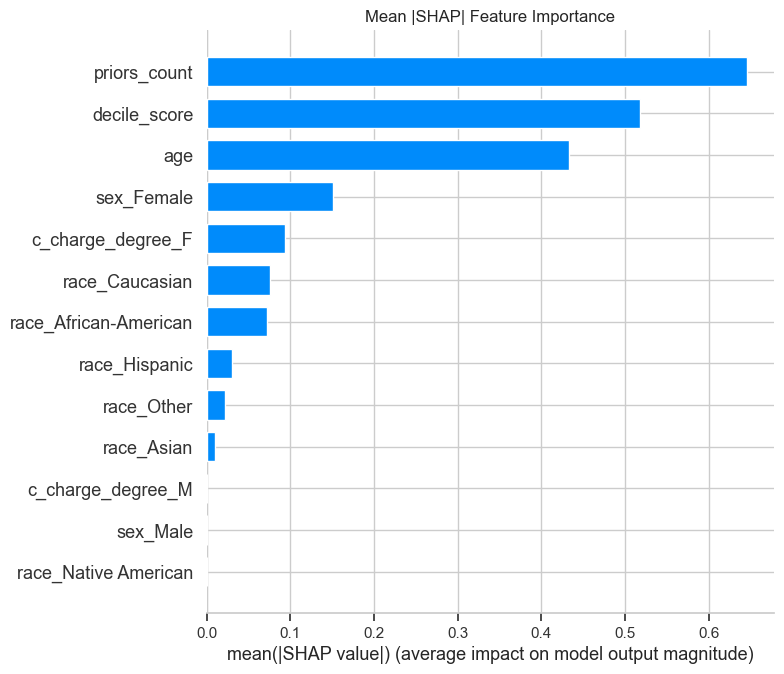

Global feature importance plot saved to figures/shap_bar.png


In [231]:


if shap_values is not None and X_test_shap is not None:
    try:
        plt.figure() 
        shap.summary_plot(shap_values, X_test_shap, plot_type="bar", show=False)
        plt.title("Mean |SHAP| Feature Importance")
        plt.savefig('figures/shap_bar.png', bbox_inches='tight')
        plt.show()
        print("Global feature importance plot saved to figures/shap_bar.png")
    except Exception as e_summary_plot:
        print(f"Error generating SHAP summary plot: {e_summary_plot}")
else:
    print("Skipping global feature importance plot: SHAP values or X_test_shap are missing.")

# ## 4. Top-5 Features Table



In [232]:


if shap_values is not None and X_test_shap is not None:
    try:
        mean_abs_shap = np.abs(shap_values).mean(axis=0)
        feature_names = X_test_shap.columns
        
        shap_summary_df = pd.DataFrame({
            'feature': feature_names,
            'mean_abs_shap': mean_abs_shap
        })
        
        top_5_features = shap_summary_df.sort_values(by='mean_abs_shap', ascending=False).head(5)
        
        print("\nTop-5 Features by Mean Absolute SHAP Value:")
        print(top_5_features)
    except Exception as e_top_features:
        print(f"Error calculating top-5 features: {e_top_features}")
else:
    print("Skipping top-5 features table: SHAP values or X_test_shap are missing.")

# ## 5. Single-Case Waterfall Explanation




Top-5 Features by Mean Absolute SHAP Value:
              feature  mean_abs_shap
1        priors_count       0.645684
0        decile_score       0.517272
2                 age       0.433598
9          sex_Female       0.151273
11  c_charge_degree_F       0.093452


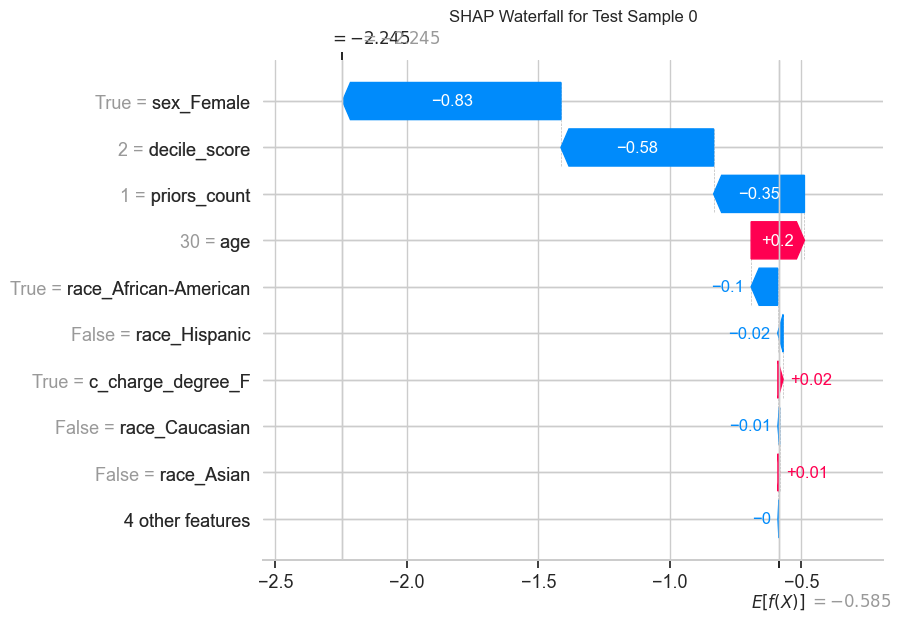

SHAP waterfall plot for sample 0 saved to figures/shap_waterfall.png

Chapter 4 (SHAP Explainability) processing complete.

Starting Conditional SHAP Analysis based on 'decile_score'...
Number of samples with decile_score < 5: 924
Number of samples with decile_score >= 5: 668
Computing SHAP values for decile_score < 5...


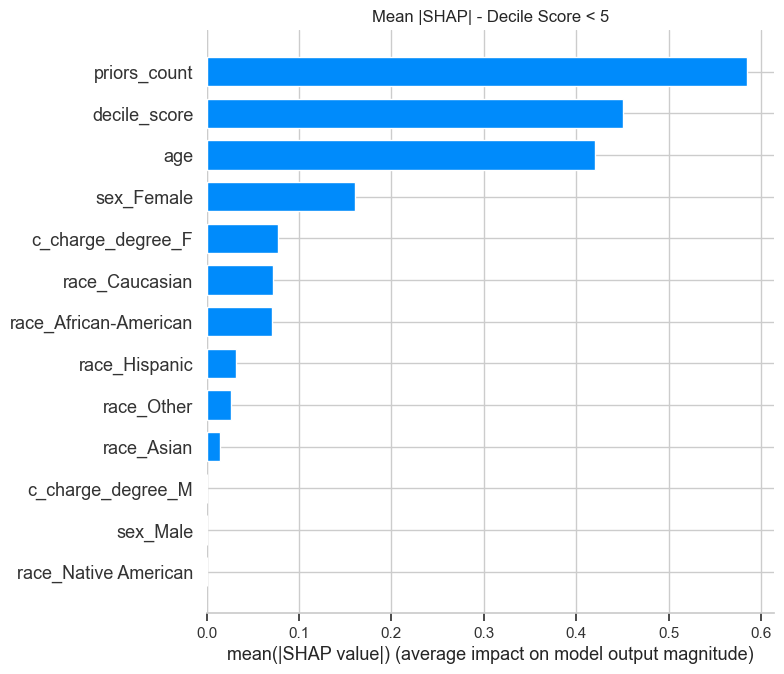

Conditional SHAP summary plot for decile_score < 5 saved to figures/shap_bar_decile_below_5.png

Computing SHAP values for decile_score >= 5...


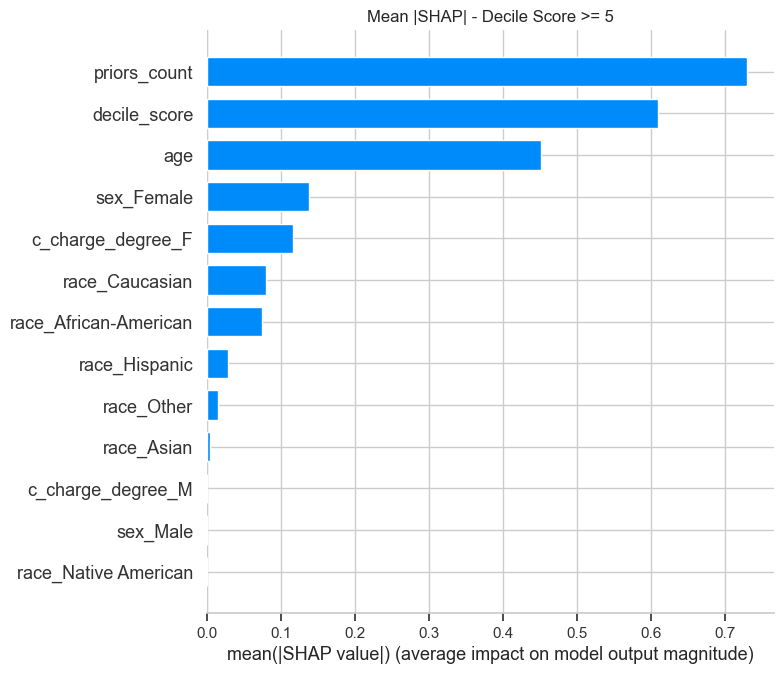

Conditional SHAP summary plot for decile_score >= 5 saved to figures/shap_bar_decile_above_5.png


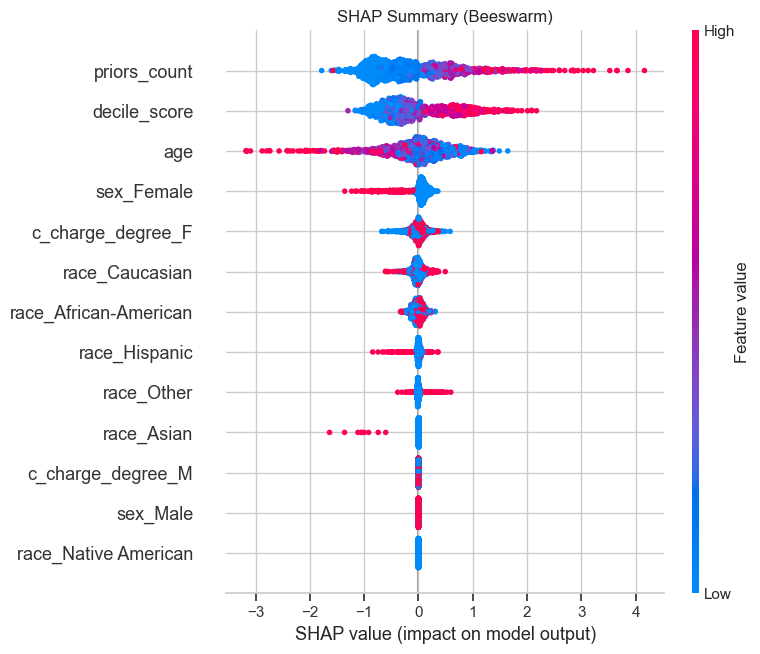

SHAP Beeswarm summary plot saved to figures/shap_beeswarm.png
Error generating SHAP dependence plot for decile_score: 'shap_values' must have the same number of columns as 'features'!


SHAP force plot for sample 0 saved to figures/shap_force_sample_0.html and displayed inline.

Chapter 4.1 (Enhanced Explainability Visualizations) processing complete.


In [233]:


if explainer is not None and shap_values is not None and X_test_shap is not None and len(X_test_shap) > 0:
    i = 0 # Index for the test sample
    if i < len(X_test_shap):
        try:
            plt.figure()
            
            # Construct SHAP Explanation object for the instance
            shap_explanation_instance = shap.Explanation(
                values=shap_values[i],
                base_values=explainer.expected_value, # E[f(x)] for the model
                data=X_test_shap.iloc[i].values,    # Actual feature values for the instance
                feature_names=X_test_shap.columns.tolist()
            )
            
            shap.plots.waterfall(shap_explanation_instance, show=False)
            
            plt.title(f"SHAP Waterfall for Test Sample {i}")
            plt.savefig(f'figures/shap_waterfall.png', bbox_inches='tight')
            plt.show()
            print(f"SHAP waterfall plot for sample {i} saved to figures/shap_waterfall.png")
        except Exception as e_waterfall:
            print(f"Error generating SHAP waterfall plot: {e_waterfall}")
    else:
        print(f"Test sample index {i} is out of bounds for X_test_shap with length {len(X_test_shap)}.")
else:
    print("Skipping single-case waterfall plot: explainer, SHAP values, or X_test_shap are missing/empty.")

# %%
# End of Chapter 4
print("\nChapter 4 (SHAP Explainability) processing complete.")

# %% [markdown]
# ## 6. Conditional SHAP Analysis (Decile Score < 5 vs. >= 5)
# This section explores how feature importance differs for individuals with a COMPAS decile score below 5 versus those with a decile score of 5 or greater.

# %%
if explainer is not None and X_test_shap is not None and 'decile_score' in X_test_shap.columns:
    print("\nStarting Conditional SHAP Analysis based on 'decile_score'...")

    # Filter X_test_shap based on decile_score
    X_test_below_5 = X_test_shap[X_test_shap['decile_score'] < 5]
    X_test_above_5 = X_test_shap[X_test_shap['decile_score'] >= 5]

    print(f"Number of samples with decile_score < 5: {len(X_test_below_5)}")
    print(f"Number of samples with decile_score >= 5: {len(X_test_above_5)}")

    if not X_test_below_5.empty:
        try:
            print("Computing SHAP values for decile_score < 5...")
            shap_values_below_5 = explainer.shap_values(X_test_below_5)
            
            plt.figure()
            shap.summary_plot(shap_values_below_5, X_test_below_5, plot_type="bar", show=False)
            plt.title("Mean |SHAP| - Decile Score < 5")
            plt.savefig('figures/shap_bar_decile_below_5.png', bbox_inches='tight')
            plt.show()
            print("Conditional SHAP summary plot for decile_score < 5 saved to figures/shap_bar_decile_below_5.png")
        except Exception as e_shap_below:
            print(f"Error during SHAP analysis for decile_score < 5: {e_shap_below}")
    else:
        print("No samples found with decile_score < 5. Skipping SHAP analysis for this subset.")

    if not X_test_above_5.empty:
        try:
            print("\nComputing SHAP values for decile_score >= 5...")
            shap_values_above_5 = explainer.shap_values(X_test_above_5)

            plt.figure()
            shap.summary_plot(shap_values_above_5, X_test_above_5, plot_type="bar", show=False)
            plt.title("Mean |SHAP| - Decile Score >= 5")
            plt.savefig('figures/shap_bar_decile_above_5.png', bbox_inches='tight')
            plt.show()
            print("Conditional SHAP summary plot for decile_score >= 5 saved to figures/shap_bar_decile_above_5.png")
        except Exception as e_shap_above:
            print(f"Error during SHAP analysis for decile_score >= 5: {e_shap_above}")
    else:
        print("No samples found with decile_score >= 5. Skipping SHAP analysis for this subset.")
        
else:
    print("\nSkipping conditional SHAP analysis: explainer, X_test_shap, or 'decile_score' column is missing.")

# %%
# This empty In[] cell is just to mimic notebook structure if converted back.
# It doesn't affect python script execution.

# %% [markdown]
# # Chapter 4.1: Enhanced Explainability Visualizations

# %% [markdown]
# ## Setup: Ensure figures/ exists
# %%
import os

os.makedirs("figures", exist_ok=True)
from IPython.display import display  # Added for force_plot

# %% [markdown]
# ## 1. SHAP Summary (Beeswarm)
# Assumes `shap_values` and `X_test_shap` are available from previous cells.
# %%
if 'shap_values' in locals() and 'X_test_shap' in locals() and shap_values is not None and X_test_shap is not None:
    try:
        plt.figure() # Create a new figure to avoid overlap
        shap.summary_plot(shap_values, X_test_shap, plot_type='dot', show=False)
        plt.title("SHAP Summary (Beeswarm)")
        plt.tight_layout()
        plt.savefig('figures/shap_beeswarm.png', bbox_inches='tight')
        plt.show()
        print("SHAP Beeswarm summary plot saved to figures/shap_beeswarm.png")
    except Exception as e:
        print(f"Error generating SHAP beeswarm plot: {e}")
else:
    print("Skipping SHAP Beeswarm plot: shap_values or X_test_shap not available.")

# %% [markdown]
# ## 2. SHAP Dependence Plot by Race
# Assumes `shap_values`, `X_test_shap`, and `df` (original DataFrame) are available.
# %%
if 'shap_values' in locals() and 'X_test_shap' in locals() and 'df' in locals() and shap_values is not None and X_test_shap is not None:
    top_feature = 'decile_score'
    if top_feature in X_test_shap.columns:
        try:
            X_test_with_race = X_test_shap.copy()
            # Ensure indices align for correct race mapping
            if X_test_shap.index.isin(df.index).all():
                X_test_with_race['race'] = df.loc[X_test_shap.index, 'race']
                
                plt.figure() # Create a new figure
                shap.dependence_plot(
                    top_feature,
                    shap_values,
                    X_test_with_race, # Use the copy that includes the race column
                    interaction_index='race',
                    show=False
                )
                plt.title(f"SHAP Dependence: {top_feature} by Race")
                plt.tight_layout()
                plt.savefig(f'figures/shap_dependence_{top_feature}_by_race.png', bbox_inches='tight')
                plt.show()
                print(f"SHAP dependence plot for {top_feature} by race saved to figures/shap_dependence_{top_feature}_by_race.png")
            else:
                print(f"Error in SHAP dependence plot: X_test_shap indices not fully in df.index. Cannot map race reliably.")

        except Exception as e:
            print(f"Error generating SHAP dependence plot for {top_feature}: {e}")
    else:
        print(f"Skipping SHAP dependence plot: top feature '{top_feature}' not in X_test_shap.columns.")
else:
    print("Skipping SHAP dependence plot: shap_values, X_test_shap, or df not available.")

# %% [markdown]
# ## 3. SHAP Force Plot for Sample 0
# Assumes `explainer`, `shap_values`, and `X_test_shap` are available.
# %%
if 'explainer' in locals() and 'shap_values' in locals() and 'X_test_shap' in locals() and explainer is not None and shap_values is not None and X_test_shap is not None:
    i = 0 # Index for the test sample
    if not X_test_shap.empty and i < len(X_test_shap):
        try:
            # Ensure display is available from IPython.display
            shap.initjs() # Initialize JavaScript for force plots
            
            force_plot = shap.force_plot(
                explainer.expected_value,
                shap_values[i],
                X_test_shap.iloc[i],
                feature_names=X_test_shap.columns.tolist() # Pass as list
            )
            
            # Display inline in notebook-like environments
            display(force_plot)
            
            # Save as HTML
            shap.save_html('figures/shap_force_sample_0.html', force_plot)
            print(f"SHAP force plot for sample {i} saved to figures/shap_force_sample_0.html and displayed inline.")
            
        except NameError as ne:
            if 'display' in str(ne):
                print("Error displaying SHAP force plot: `display` function not found. Ensure you are in an IPython environment and `from IPython.display import display` has been run.")
            else:
                print(f"Error generating SHAP force plot for sample {i}: {ne}")
        except Exception as e:
            print(f"Error generating SHAP force plot for sample {i}: {e}")
    else:
        print(f"Skipping SHAP force plot: X_test_shap is empty or sample index {i} is out of bounds.")
else:
    print("Skipping SHAP force plot: explainer, shap_values, or X_test_shap not available.")

# %%
print("\nChapter 4.1 (Enhanced Explainability Visualizations) processing complete.")

